**Introduction:**
Here we are going to perform Image classification for ecommerce company Cdiscount. We will perform them on 1500 categories.
We have three source files as:
1. Categories.csv: This will contain all categories present in our trainning file along with their hierarchies.
2. Train_example.bson: This is small source file extracted as top 82 objects from main training file. We will use this file for our exploration purpose
3. Train.bson: This is our main source data file. We will use this file as our training file. We will extract 1500 categories and will perform our algorithms for classification

In [1]:
import pandas as pd
import numpy as np
import bson
import io
import os
import matplotlib.pyplot as plt
import cv2
from skimage.data import imread
import struct
from keras.layers import Conv2D, MaxPooling2D,Dropout,Dense, Flatten
from keras.models import Sequential
import tqdm
from PIL import Image
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

Using TensorFlow backend.


**Before getting started with our actual exploration lets see the number of categories present in our training file**
In the below file we can find there are 5270 overall categories with 49 level1 categories, 483 level2 and 5263 level3 categories

In [76]:
category_list=pd.read_csv('category_names.csv')
category_list.head()

,category_id,category_level1,category_level2,category_level3
0,1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA
1,1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR
2,1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO
3,1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU
4,1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR


In [46]:
print(len(category_list["category_id"].unique()))
print(len(category_list["category_level1"].unique()))
print(len(category_list["category_level2"].unique()))
print(len(category_list["category_level3"].unique()))

5270
49
483
5263


**Defining the source file paths**

In [65]:
path=""
train_directory=os.path.join(path,'train.bson')
train_example=os.path.join(path,'train_example.bson')

**Extracting the Data**

The below function extracts the data from thensource file. we can see that there are two for loops used. The first for loop is used to iterate over objects in bson file and second to iterate over images stored in each object

In [63]:
def read_bson(path_bson):
    categories=[]
    images=[]
    with open(path_bson,'rb')as f:
        data=bson.decode_file_iter(f)
        for i,j in enumerate(data):
            category=j['category_id']
            for a,pic in enumerate(j['imgs']):
                categories.append(category)
                picture=imread(io.BytesIO(pic['picture']))
                images.append(picture)
            if len(set(categories))==1500:
                break
    return images,categories        

In [79]:
image_example,category_example=read_bson(train_example)

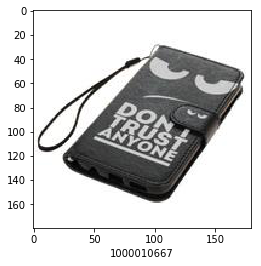

In [80]:
img=np.array(image_example)
plt.imshow(img[107])
plt.xlabel(category_example[107])
plt.show()

**Extracting the data**

In [66]:
image,category=read_bson(train_directory)

**Now we will try to plot the distribution of images per category**

In [111]:
data=bson.decode_file_iter(open(train_directory,'rb'))
categories=[]
img=[]
for i,j in enumerate(data):
    categories.append(j['category_id'])
    img.append(len(j['imgs']))
    if len(set(categories))==1500:
        break

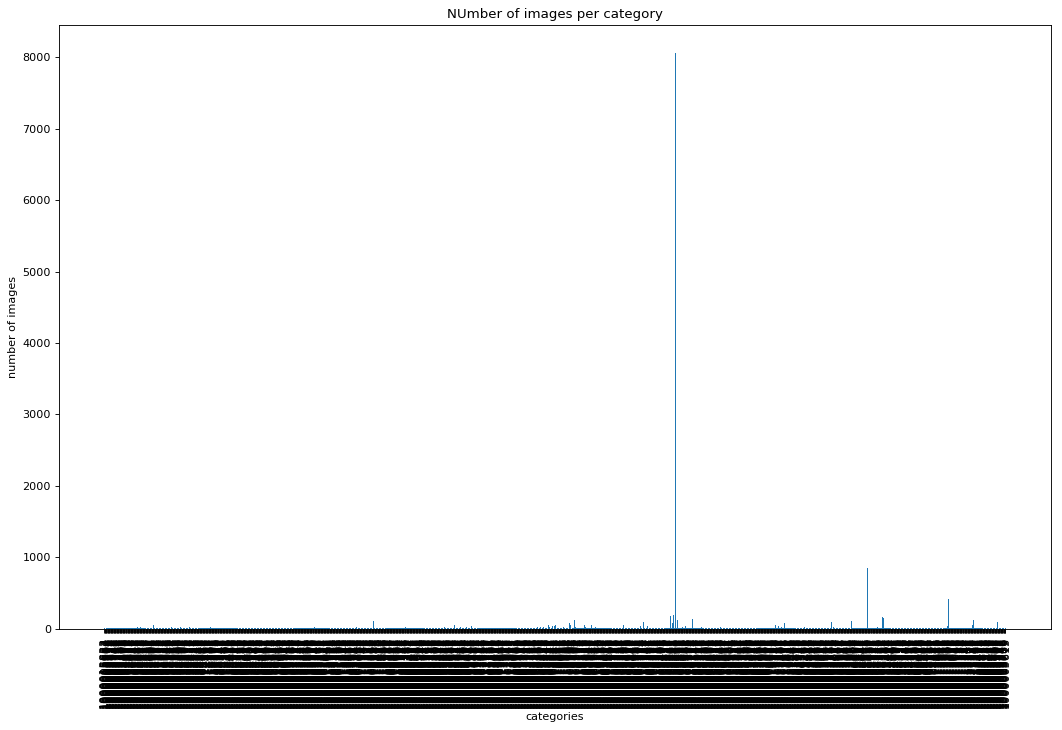

In [112]:
dta_dict={'categories':categories,'no_images':imgs}
analysis=pd.DataFrame(dta_dict)
categories=list(set(analysis['categories']))
total_images=[]
for i in categories:
    total_images.append(np.sum(analysis['no_images'][analysis['categories']==i]))
final_dict={'categories':categories,'no_images':total_images}
final_df=pd.DataFrame(final_dict)
n=np.array(range(len(categories)))
plt.figure(num=None, figsize=(16, 10), dpi=80)
plt.bar(n,final_df['no_images'])
plt.xticks(n,final_df['categories'], rotation='vertical')
plt.title('NUmber of images per category')
plt.xlabel('categories')
plt.ylabel('number of images', rotation='vertical')
plt.show()

**Creating Benchmark Model**

Lets, Create our benchmark model for our data which will be used for comparing our trained model. we will be using naive predictor to create benchmark model

In [8]:
#Naive predictor

most_common,num_most_common = Counter(category).most_common(1)[0]
naive_pred=[]
naive_pred=[most_common for i in range(len(category))]
accuracy=accuracy_score(category,naive_pred)
print("The maximum occuraing category is:",most_common,"and occurance is:",num_most_common)
print("The naive Accuracy or benchmark is:",accuracy)
print("The description of the category is:\n")
category_list[category_list["category_id"]==most_common]

The maximum occuraing category is: 1000010653 and occurance is: 8056
The naive Accuracy or benchmark is: 0.328494535965
The description of the category is:



,category_id,category_level1,category_level2,category_level3
5055,1000010653,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE


**Creating Onehot Encoding and shuffling our data**
We will do the Onehotcoding our our category id with the help of factorize as below.
While observing the data we found that the data extracted is grouped as per the categories. This will hamper the performance of our model, as it may train some categories and some will remain in testing data without getting trained. Hence will shuffle our data.

In [67]:
#Onehotencoding for category
#converting image into array 
#shuffling images
y,rev_labels=pd.factorize(category)
image_shuffle,category_shuffle=shuffle(image,y)
image_shuffle=np.array(image_shuffle)
image_float=image_shuffle.astype('float32')/255

In [72]:
training_image=image_float[:20000]
training_labels=category_shuffle[:20000]
testing_image=image_float[20000:]
testing_labels=category_shuffle[20000:]

In [3]:
model=Sequential()
model.add(Conv2D(16,3,activation='relu',input_shape=(180,180,3)))
model.add(Conv2D(32,3,activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))
model.add(Conv2D(64,3,activation='relu'))
model.add(Conv2D(64,3,activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))
model.add(Conv2D(32,3,activation='relu'))
model.add(Conv2D(16,3,activation='relu'))
model.add(MaxPooling2D(2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1500,activation='softmax'))

In [4]:
model.compile('Adam','sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 178, 178, 16)      448       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 176, 176, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 88, 88, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 86, 86, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 84, 84, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 42, 42, 64)        0         
__________

In [16]:
from keras.callbacks import ModelCheckpoint  
epochs = 5
checkpointer = ModelCheckpoint(filepath='checkpoints/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

In [17]:
model.fit(training_image,training_labels,batch_size=50, epochs=5, verbose=1,validation_split=0.2,callbacks=[checkpointer])

Train on 16000 samples, validate on 4000 samples
Epoch 1/5
16000/16000 [==============================] - 2349s - loss: 4.1835 - acc: 0.3228 - val_loss: 3.7863 - val_acc: 0.3663
Epoch 2/5
16000/16000 [==============================] - 2347s - loss: 3.4120 - acc: 0.3864 - val_loss: 3.5062 - val_acc: 0.4190
Epoch 3/5
16000/16000 [==============================] - 2348s - loss: 2.3709 - acc: 0.4627 - val_loss: 3.6469 - val_acc: 0.4605
Epoch 4/5
16000/16000 [==============================] - 2348s - loss: 1.4951 - acc: 0.6151 - val_loss: 3.9529 - val_acc: 0.4742
Epoch 5/5
16000/16000 [==============================] - 2347s - loss: 1.0937 - acc: 0.6966 - val_loss: 4.0952 - val_acc: 0.4855


In [5]:
model.load_weights('checkpoints/weights.best.from_scratch.hdf5')

In [73]:
acc=[]
from sklearn.metrics import accuracy_score
pred=model.predict(testing_image)
for i in pred:
    acc.append(np.argmax(i))
accuracy=accuracy_score(testing_labels,acc)
print("The accuracy of the model is:", accuracy)

The accuracy of the model is: 0.432139699381


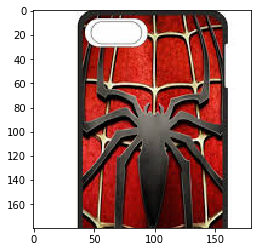

In [83]:
image_list=[]
image=Image.open('Valid_Images/images.jpg')
image=np.array(image)
image=image[:180,:180]
image.shape
plt.imshow(image)
plt.show()

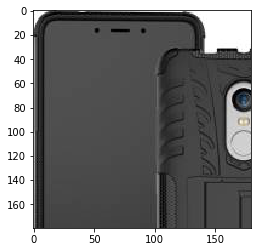

In [82]:
image2=Image.open('Valid_Images/chevron-chevshock-023-original-imaesgt8b48dgnzs.jpeg')
image2=np.array(image2)
image2=image2[:180,:180]
image2.shape
plt.imshow(image2)
plt.show()

In [84]:
image_list.append(image)

In [85]:
image_list.append(image2)

In [86]:
image_list=np.array(image_list)

In [87]:
image_list=image_list.astype('float32')/255

In [88]:
acc=[]
from sklearn.metrics import accuracy_score
pred=model.predict(image_list)
for i in pred:
    acc.append(np.argmax(i))
for i in acc:
    print(rev_labels[i])

1000010653
1000010667


In [81]:
category_list[category_list['category_id']==1000010653]

,category_id,category_level1,category_level2,category_level3
5055,1000010653,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,COQUE TELEPHONE - BUMPER TELEPHONE


In [89]:
category_list[category_list['category_id']==1000010667]

,category_id,category_level1,category_level2,category_level3
5067,1000010667,TELEPHONIE - GPS,ACCESSOIRE TELEPHONE,HOUSSE - ETUI - CHAUSSETTE


**Conclusion: **

Thus, we have implemented the classinication of images as per their labels with accuracy 0.42. We trained on 16000 images validated on 4000 images and tested on 4424 images. The data is very imbalanced as we can see one category was having more that 30% of the data. 